In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

try: 
    from google.colab.patches import cv2_imshow
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError: 
    print("not using colab.")


not using colab.


# Setting up PHD Filter
This portion pulls and builds the filter code. If you have the filter code pulled, make sure to navigate "cd" into that directory.

In [ ]:
!git clone https://github.com/MobileRoboticistsW21/PHD-object-traking.git

In [ ]:
%cd PHD-object-traking/

In [ ]:
!git checkout main   # can change this to main if branch is merged 
!git pull

In [ ]:
%cd /content/PHD-object-traking/
!bash setup.sh

In [34]:
!mkdir build
%cd build
!cmake ..
!make phd_json_dump
!./phd_json_dump
%cd ../

mkdir: cannot create directory ‘build’: File exists
/home/baldeeb/Documents/530/PHD-object-traking/build
-- A library with LAPACK API found.
-- Configuring done
-- Generating done
-- Build files have been written to: /home/baldeeb/Documents/530/PHD-object-traking/build
[100%] Built target phd_json_dump
enter the relative data file directory: ^C
/home/baldeeb/Documents/530/PHD-object-traking


In [ ]:
!./phd_json_dump
# enter this: ../data/first_20_frame_optical_res.json

# Visualization and Testing

Be sure to set the correct data paths for the code to run as expected.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import cv2
import numpy as np

In [29]:
VIDEO_NAME = "MOT16-09"
images_dir = None # "/content/drive/My Drive/Mask_RCNN_stuff/" + VIDEO_NAME
filtered_data_dir = "data/output/filtered_"+VIDEO_NAME+".json"
detection_data_dir = "data/" + VIDEO_NAME + "_optical_flow_res.json"
ground_truth_dir = ""

In [30]:
with open(filtered_data_dir, encoding='UTF-8', errors='ignore') as inputFile:
    data_out = json.load(inputFile)
with open(detection_data_dir, encoding='UTF-8', errors='ignore') as inputFile:
    data_input = json.load(inputFile)
if images_dir:
    images = os.listdir(images_dir)
    images.sort()

<ipython-input-31-d595a884c67d>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


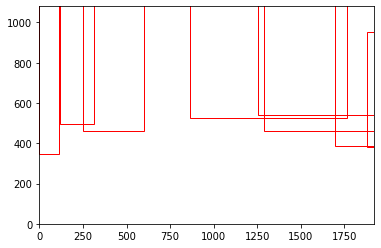

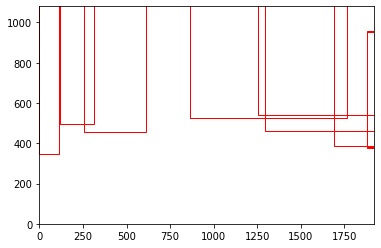

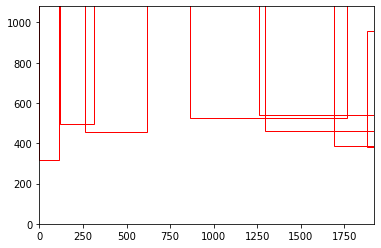

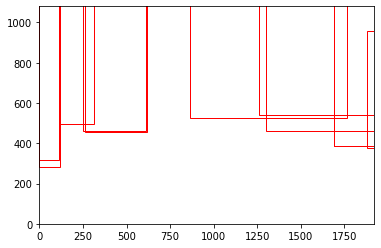

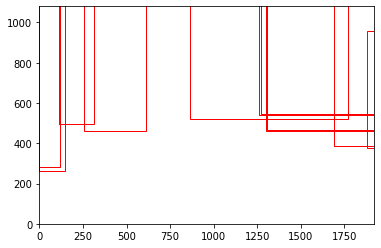

In [31]:
from python_utils.box_vis_utils import xywh_to_corners

disp_frames = 5
for i in range(min(disp_frames, len(data_out))):
    bbs = data_out[i]['bb']
    plt.clf(); plt.xlim(0, 1920); plt.ylim(0, 1080)
    ax = plt.axes()
    for bb in bbs:
        c = xywh_to_corners([bb])[0]
        rect = patches.Rectangle((c[0], c[1]), c[2], c[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    # plt.show()
    plt.pause(0.25)


In [1]:
# make a folder to store images
!mkdir temp_images_folder
%cd temp_images_folder
!pwd

/home/mingshuo/PHD-object-traking/temp_images_folder
/home/mingshuo/PHD-object-traking/temp_images_folder


In [ ]:
# Miracle + Mingshuo's code to visualize Genertated & Mask RCNN Boxes with images.
from python_utils.box_vis_utils import xywh_to_corners

for image_name,in_data, gen_data in zip(images[0:-2], data_input, data_out):             # number of frames
  image = cv2.imread(os.path.join(images_dir, image_name))
  # I am assuming that data is still outputting xywh formatted data
  data_tlbr_in = xywh_to_corners(in_data['bb'])
  data_tlbr_gen = xywh_to_corners(gen_data['bb'])
  for bbox_in in data_tlbr_in:
    # right now its in xywh so covert to tlbr
    cv2.rectangle(image, (int(bbox_in[0]), int(bbox_in[1])), (int(bbox_in[2]), int(bbox_in[3])),(100,255,0,0.1), 5)
  for bbox_gen in data_tlbr_gen:
    cv2.rectangle(image, (int(bbox_gen[0]), int(bbox_gen[1])), (int(bbox_gen[2]), int(bbox_gen[3])),(255,100,50), 2)
  # cv2_imshow(image)
  print("saving image # ",image_name)
  cv2.imwrite((VIDEO_NAME + '_' + image_name), image)
  cv2.waitKey(0) 

In [ ]:
# Combine image frames into a video with original resolution
import cv2
import numpy as np


image_file_names = os.listdir('.')
image_file_names = [x for x in image_file_names if x.startswith(VIDEO_NAME)]
image_file_names.sort()
print(image_file_names)
assert(len(image_file_names) > 0)

img = cv2.imread(os.path.join(os.getcwd() ,image_file_names[0]))
height,width,layers = img.shape

fourcc = fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
fps = 25

video=cv2.VideoWriter('/content/'+VIDEO_NAME+'_phd_filter_viz_video_short.mp4', \
                      fourcc, fps,(width,height))

for image_file_name in image_file_names:
  img = cv2.imread(os.path.join(os.getcwd() ,image_file_name))
  print("writing in image# ", image_file_name)
  video.write(img)

cv2.destroyAllWindows()
video.release()

# Assign random IDs for tracks

In its current state the filter does not track IDs. Evaluation code for MOT expects IDs. This code is a workaround so we can run evaluation.

In [24]:


from python_utils.id_assigner import assign_ids_postfact

data = assign_ids_postfact(data_out)
with open('data/output/filtered_' + VIDEO_NAME + '_with_ids.json', 'w') as outfile:
    json.dump(data, outfile, indent=4)